Section 1(Normalization)

In [26]:
# Min-Max Normalization for Hyperspectral Data
import pandas as pd                       # For reading/writing Excel/CSV and handling DataFrames
from sklearn.preprocessing import MinMaxScaler   # For Min-Max scaling of features

#  Load the dataset 
input_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/full_dataset_filtered.xlsx"  # Path to Excel file
df = pd.read_excel(input_path)            # Read the Excel file into a DataFrame

print("Original Columns:", df.columns.tolist())   # Show all column names for verification
print("Shape before:", df.shape)                  # Print dataset shape (rows, columns) before preprocessing

#  Drop unwanted columns 
drop_cols = ['Image ID', 'Minimum Reflectance', 'Otsu Threshold']  # Columns to remove
df = df.drop(columns=drop_cols, errors='ignore')  # Drop them; ignore errors if any column not present

#  Separate target column 
target_col = 'Yield'                      # This is the target variable
y = df[target_col]                         # Store Yield separately (we don’t normalize it)
X = df.drop(columns=[target_col])          # All other columns are features to normalize

#  Min-Max normalization 
scaler = MinMaxScaler()                    # Create MinMaxScaler instance (default range: 0–1)
X_scaled = scaler.fit_transform(X)         # Fit scaler to features & transform them into scaled array

#  Reconstruct DataFrame 
normalized_df = pd.DataFrame(X_scaled, columns=X.columns)  # Convert scaled array back to DataFrame with original column names
normalized_df[target_col] = y                               # Add back the original Yield column (unscaled)
normalized_df = normalized_df.round(2) 
print("Shape after normalization:", normalized_df.shape)    # Print new shape after dropping columns and adding scaled features

#  Save processed file 
output_path = "normalized_minmax_with_target_2.csv"           # Output file name (will save in current working directory)
normalized_df.to_csv(output_path, index=False)              # Save normalized data to CSV without row index

print(f"✅ Normalized file saved as: {output_path}")         # Confirmation message after saving


Original Columns: ['400 nm', '402 nm', '405 nm', '408 nm', '411 nm', '414 nm', '417 nm', '420 nm', '423 nm', '426 nm', '429 nm', '432 nm', '435 nm', '438 nm', '441 nm', '444 nm', '447 nm', '450 nm', '453 nm', '456 nm', '459 nm', '462 nm', '465 nm', '467 nm', '470 nm', '473 nm', '476 nm', '479 nm', '482 nm', '485 nm', '488 nm', '491 nm', '494 nm', '497 nm', '500 nm', '503 nm', '506 nm', '509 nm', '512 nm', '515 nm', '518 nm', '521 nm', '524 nm', '527 nm', '530 nm', '533 nm', '535 nm', '538 nm', '541 nm', '544 nm', '547 nm', '550 nm', '553 nm', '556 nm', '559 nm', '562 nm', '565 nm', '568 nm', '571 nm', '574 nm', '577 nm', '580 nm', '583 nm', '586 nm', '589 nm', '592 nm', '595 nm', '598 nm', '600 nm', '603 nm', '606 nm', '609 nm', '612 nm', '615 nm', '618 nm', '621 nm', '624 nm', '627 nm', '630 nm', '633 nm', '636 nm', '639 nm', '642 nm', '645 nm', '648 nm', '651 nm', '654 nm', '657 nm', '660 nm', '663 nm', '666 nm', '668 nm', '671 nm', '674 nm', '677 nm', '680 nm', '683 nm', '686 nm', '

Section 2(KS)

In [ ]:
# Data partition using KS (Kennard–Stone) method
import pandas as pd                       # For handling CSV files and tabular data
import numpy as np                        # For numerical operations
from scipy.spatial.distance import cdist  # To compute pairwise Euclidean distances

# Load dataset from CSV file
input_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/normalized_minmax_with_target_2.csv"
df = pd.read_csv(input_path)              # Read CSV into pandas DataFrame

# Identify columns to keep (not for splitting)
keep_cols = ['Image ID', 'Yield', 'Minimum Reflectance', 'Otsu'] # Keep only the columns that actually exist in the dataset 

keep_cols_existing = [col for col in keep_cols if col in df.columns]  # Select remaining columns (hyperspectral bands) for splitting

X_cols = [col for col in df.columns if col not in keep_cols_existing]  
X = df[X_cols].values                     # Extract band values as NumPy array for KS algorithm

# Define Kennard–Stone algorithm function
def kennard_stone(X, n_samples):
    n_total = X.shape[0]                              # Total number of samples
    dist_matrix = cdist(X, X, metric='euclidean')     # Compute pairwise Euclidean distance matrix
    
    # Step 1: select two samples farthest apart
    i1, i2 = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)  
    selected = [i1, i2]                               # Start with two farthest points
    remaining = list(set(range(n_total)) - set(selected))  # Remaining samples to select from
    
    # Step 2: iteratively select sample farthest from selected set
    while len(selected) < n_samples:
        # Compute minimum distance of each remaining sample to any selected sample
        dist_to_selected = np.min(dist_matrix[remaining][:, selected], axis=1)  
        next_idx = remaining[np.argmax(dist_to_selected)]  # Pick the one with maximum distance
        selected.append(next_idx)                           # Add to selected list
        remaining.remove(next_idx)                          # Remove from remaining
    
    return selected  # Return list of selected indices for training set

# Split dataset into training and test sets
n_train = int(0.8 * X.shape[0])   # 80% of samples for training
train_idx = kennard_stone(X, n_train)  # Get training indices using KS algorithm
test_idx = list(set(range(X.shape[0])) - set(train_idx))  # Remaining samples for testing

# Create DataFrames for train and test sets
df_train = df.iloc[train_idx].reset_index(drop=True)  # Training set
df_test = df.iloc[test_idx].reset_index(drop=True)    # Test set

# Save train and test sets to CSV files
df_train.to_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv", index=False)
df_test.to_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv", index=False)

# Print confirmation and dataset shapes
print("✅ Kennard–Stone split done!")  
print("Train set shape:", df_train.shape)
print("Test set shape :", df_test.shape)


✅ Kennard–Stone split done!
Train set shape: (1102, 205)
Test set shape : (473, 205)


Section 3(PLSR)

In [6]:
# Train using PLSR (Partial Least Squares Regression) technique
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
from sklearn.cross_decomposition import PLSRegression  # PLS regression model
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics

# Load train and test datasets
train_df = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv")  # Load training CSV
test_df = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv")  # Load testing CSV

print("Train shape:", train_df.shape)  # Show training data shape
print("Test shape:", test_df.shape)  # Show testing data shape

# Separate features (X) and target (y)
target_column = "Yield"  # Replace with your actual target column name
X_train = train_df.drop(columns=[target_column])  # Features for training
y_train = train_df[target_column]  # Target for training

X_test = test_df.drop(columns=[target_column])  # Features for testing
y_test = test_df[target_column]  # Target for testing

# Standardize the feature data
scaler = StandardScaler()  # Initialize scaler
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training features
X_test_scaled = scaler.transform(X_test)  # Transform testing features with same scaler

# Train PLSR model with up to 10 components
n_components = min(X_train.shape[1], 50)  # Choose number of components (max 10 or number of features)
pls = PLSRegression(n_components=n_components)  # Initialize PLS model
pls.fit(X_train_scaled, y_train)  # Fit PLS model to training data

# Make predictions
y_pred_train = pls.predict(X_train_scaled)  # Predict on training set
y_pred_test = pls.predict(X_test_scaled)  # Predict on testing set

# Evaluate model performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))  # RMSE for training
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))  # RMSE for testing

train_r2 = r2_score(y_train, y_pred_train)  # R² for training
test_r2 = r2_score(y_test, y_pred_test)  # R² for testing

train_rpd = np.std(y_train, ddof=1) / train_rmse  # RPD for training
test_rpd = np.std(y_test, ddof=1) / test_rmse  # RPD for testing

print("\nPLSR Model Evaluation:")  # Print evaluation header
print(f"Train R²             : {train_r2:.4f}")  # Display training R²
print(f"Test R²              : {test_r2:.4f}")  # Display testing R²
print(f"Train RMSE           : {train_rmse:.4f}")  # Display training RMSE
print(f"Test RMSE            : {test_rmse:.4f}")  # Display testing RMSE
print(f"Train RPD            : {train_rpd:.4f}")  # Display training RPD
print(f"Test RPD             : {test_rpd:.4f}")  # Display testing RPD


Train shape: (1272, 205)
Test shape: (318, 205)

PLSR Model Evaluation:
Train R²             : 0.7632
Test R²              : 0.5667
Train RMSE           : 1017.2132
Test RMSE            : 1378.3958
Train RPD            : 2.0559
Test RPD             : 1.5216



 Starting RandomizedSearchCV for PLSR...
Fitting 10 folds for each of 10 candidates, totalling 100 fits

 Best Parameters found:
{'n_components': np.int64(11)}
 Best Cross-Validation R²: 0.6531445736234803

 Best PLSR model saved as PLSR_model_best.pkl

 PLSR Model Evaluation (RandomizedSearchCV):
Train R²   : 0.6795
Test R²    : 0.6200
Train RMSE : 1183.4180
Test RMSE  : 1290.8190
Train RPD  : 1.7672
Test RPD   : 1.6249


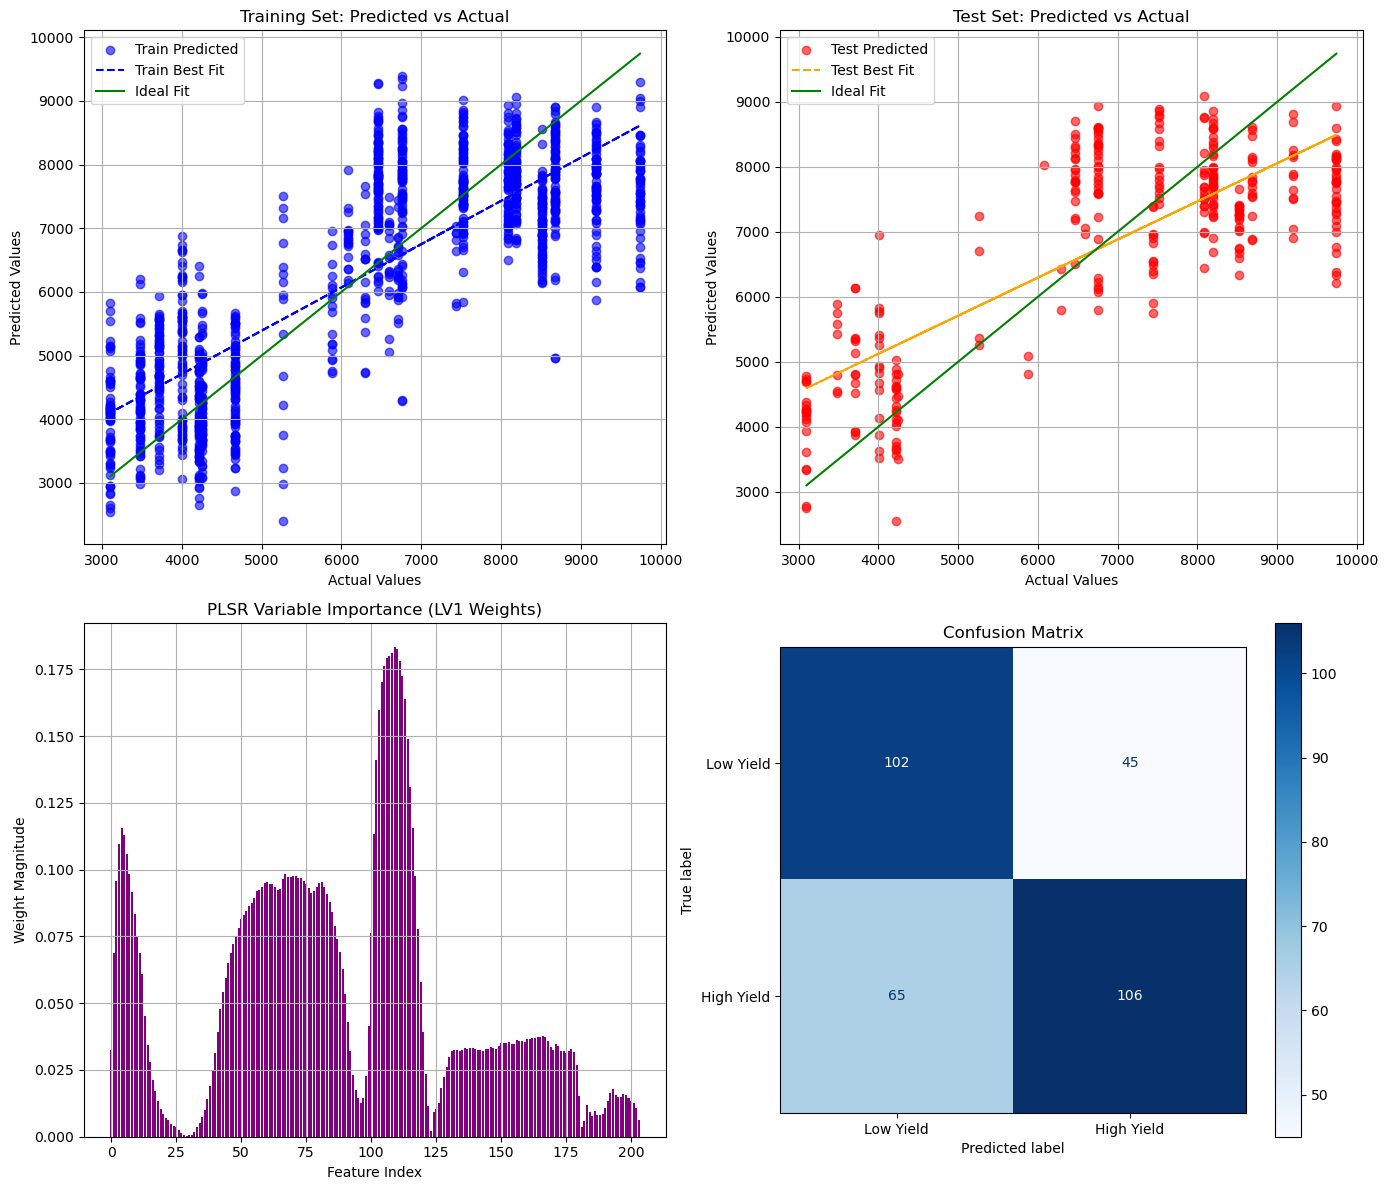

In [9]:
# Partial Least Squares Regression (PLSR) + RandomizedSearchCV
import pandas as pd  # For handling CSV data
import numpy as np  # For numerical computations
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.cross_decomposition import PLSRegression  # PLSR model
from sklearn.model_selection import RandomizedSearchCV  # Randomized hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay  # Evaluation metrics
import matplotlib.pyplot as plt  # For visualization
import pickle  # For saving model and scaler

# 1. Load train and test datasets
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 2. Split features (X) and target (Y)
target_column = "Yield"  # Dependent variable
X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test = test_df.drop(columns=[target_column]).values
y_test = test_df[target_column].values

# 3. Standardize features for PLSR
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Save the scaler for later use
with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# 4. Define PLSR model
pls = PLSRegression(scale=False)  # Already scaled data

# 5. Define parameter search space for RandomizedSearchCV
param_distributions = {
    'n_components': np.arange(2, min(X_train.shape[1], 12))  # Randomly choose number of latent variables (2–30)
}

# 6. Set up RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    estimator=pls,               # PLSR model
    param_distributions=param_distributions,  # Search range
    n_iter=10,                   # Number of random combinations to test
    scoring='r2',                # Evaluation metric
    cv=10,                       # 10-fold cross-validation
    random_state=42,             # Reproducibility
    n_jobs=-1,                   # Use all CPU cores
    verbose=2                    # Show progress
)

print("\n Starting RandomizedSearchCV for PLSR...")
random_search.fit(X_train_scaled, y_train)

# 7. Display the best result
print("\n Best Parameters found:")
print(random_search.best_params_)
print(" Best Cross-Validation R²:", random_search.best_score_)

# Get the best model
best_pls = random_search.best_estimator_

# 8. Save best model
with open("PLSR_model_best.pkl", "wb") as f:
    pickle.dump(best_pls, f)
print("\n Best PLSR model saved as PLSR_model_best.pkl")

# 9. Predictions on train and test sets
y_pred_train = best_pls.predict(X_train_scaled).ravel()
y_pred_test = best_pls.predict(X_test_scaled).ravel()

# 10. Define evaluation function (R², RMSE, RPD)
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

# Compute metrics
train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)

# 11. Print evaluation summary
print("\n PLSR Model Evaluation (RandomizedSearchCV):")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test RPD   : {test_rpd:.4f}")

# 12. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# (a) Train Predicted vs Actual
axes[0, 0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')
z_train = np.polyfit(y_train, y_pred_train, 1)
p_train = np.poly1d(z_train)
axes[0, 0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")
axes[0, 0].set_title("Training Set: Predicted vs Actual")
axes[0, 0].set_xlabel("Actual Values")
axes[0, 0].set_ylabel("Predicted Values")
axes[0, 0].legend()
axes[0, 0].grid(True)

# (b) Test Predicted vs Actual
axes[0, 1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')
z_test = np.polyfit(y_test, y_pred_test, 1)
p_test = np.poly1d(z_test)
axes[0, 1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")
axes[0, 1].set_title("Test Set: Predicted vs Actual")
axes[0, 1].set_xlabel("Actual Values")
axes[0, 1].set_ylabel("Predicted Values")
axes[0, 1].legend()
axes[0, 1].grid(True)

# (c) Feature Importance (LV1 Weights)
axes[1, 0].bar(range(X_train.shape[1]), np.abs(best_pls.x_weights_[:, 0]), color='purple')
axes[1, 0].set_title("PLSR Variable Importance (LV1 Weights)")
axes[1, 0].set_xlabel("Feature Index")
axes[1, 0].set_ylabel("Weight Magnitude")
axes[1, 0].grid(True)

# (d) Confusion Matrix (High vs Low Yield classification-like visualization)
y_test_class = (y_test >= np.median(y_test)).astype(int)
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)
cm = confusion_matrix(y_test_class, y_pred_test_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])
disp.plot(ax=axes[1, 1], cmap=plt.cm.Blues, values_format="d")
axes[1, 1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()



 Starting GridSearchCV for PLSR...
Fitting 10 folds for each of 10 candidates, totalling 100 fits

 Best Parameters found: {'n_components': 11}
 Best CV (lowest MSE): 1472886.3384
 Selected LVs: 11

 Best PLSR model saved as PLSR_model_best.pkl

PLSR Model Evaluation:
Train R²   : 0.6795
Test R²    : 0.6200
Train RMSE : 1183.4180
Test RMSE  : 1290.8190
Train RPD  : 1.7672
Test RPD   : 1.6249


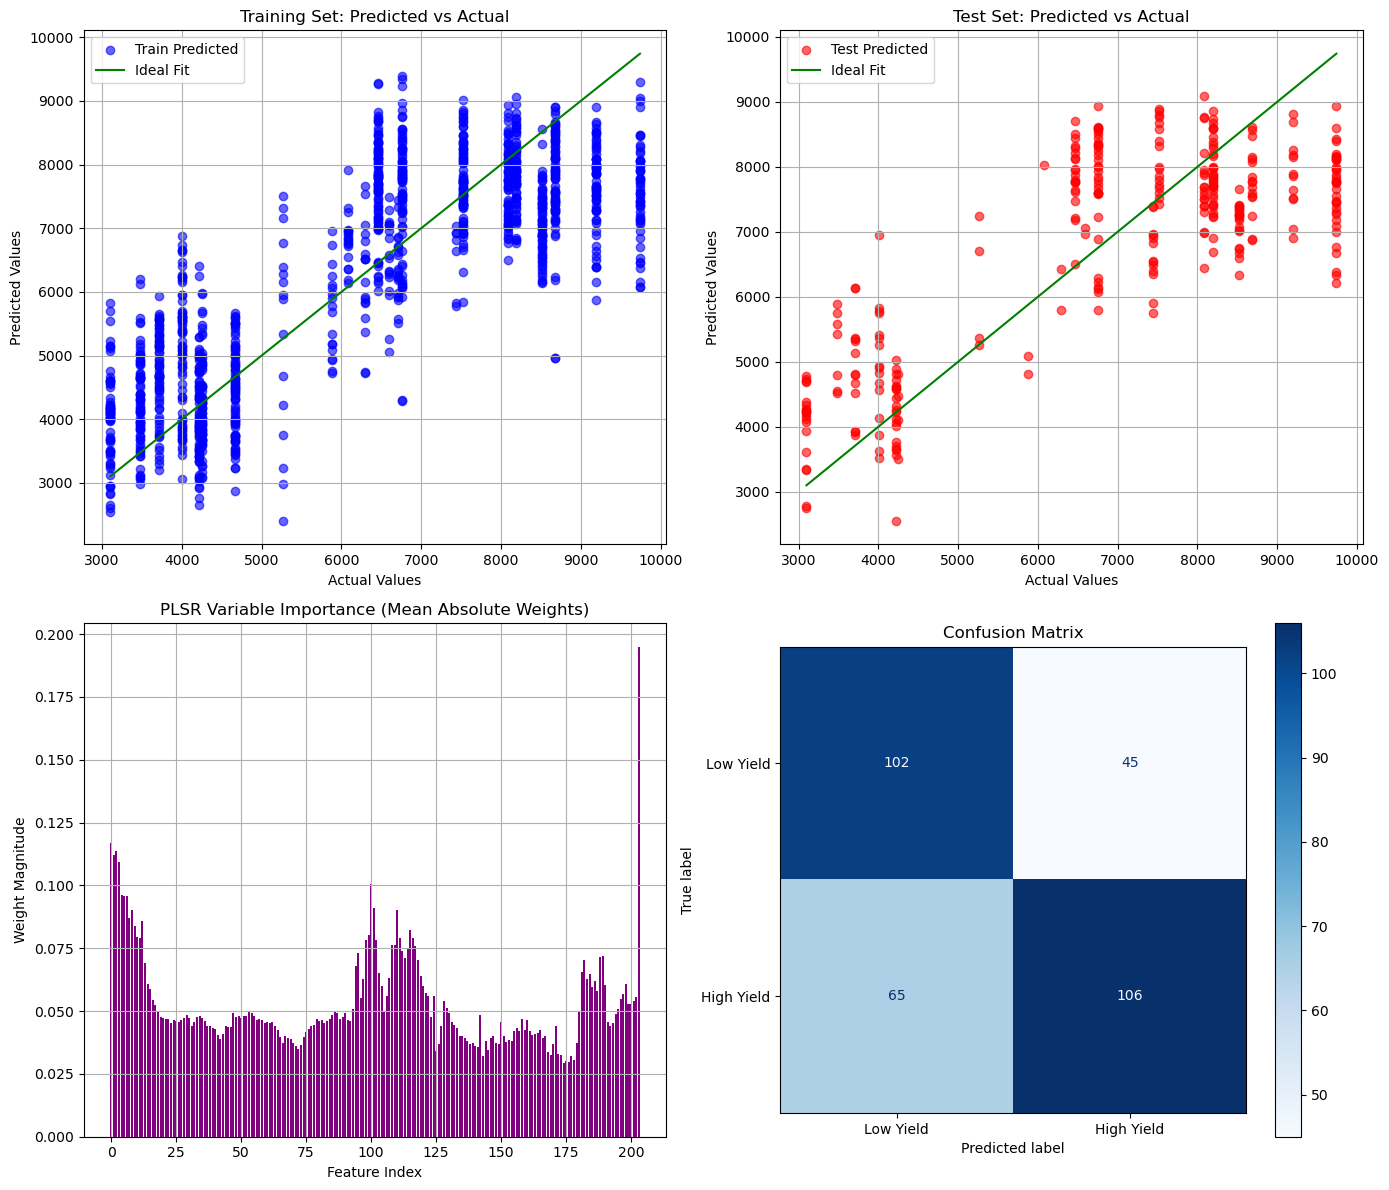

In [ ]:
# Partial Least Squares Regression (PLSR) + GridSearchCV
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

# 1. Load CSV files
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 2. Separate features and target
target_column = "Yield"
X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test = test_df.drop(columns=[target_column]).values
y_test = test_df[target_column].values

# 3. Standardize only X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# 4. Hyperparameter tuning: number of latent variables
param_grid = {
    'n_components': list(range(2, min(X_train_scaled.shape[1], 12)))  # test up to 25 LVs if possible
}

pls = PLSRegression(scale=False)

cv_strategy = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pls,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # better for minimizing RMSECV
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2
)

print("\n Starting GridSearchCV for PLSR...")
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_pls = grid_search.best_estimator_
best_ncomp = grid_search.best_params_['n_components']
print(f"\n Best Parameters found: {grid_search.best_params_}")
print(f" Best CV (lowest MSE): {-grid_search.best_score_:.4f}")
print(f" Selected LVs: {best_ncomp}")

# Save model
with open("PLSR_model_best.pkl", "wb") as f:
    pickle.dump(best_pls, f)
print("\n Best PLSR model saved as PLSR_model_best.pkl")

# 5. Predictions
y_pred_train = best_pls.predict(X_train_scaled).ravel()
y_pred_test = best_pls.predict(X_test_scaled).ravel()

# 6. Evaluation
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)

print("\nPLSR Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test RPD   : {test_rpd:.4f}")

# 7. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Train Scatter Plot
axes[0, 0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                "green", linestyle='-', label="Ideal Fit")
axes[0, 0].set_title("Training Set: Predicted vs Actual")
axes[0, 0].set_xlabel("Actual Values")
axes[0, 0].set_ylabel("Predicted Values")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Test Scatter Plot
axes[0, 1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                "green", linestyle='-', label="Ideal Fit")
axes[0, 1].set_title("Test Set: Predicted vs Actual")
axes[0, 1].set_xlabel("Actual Values")
axes[0, 1].set_ylabel("Predicted Values")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Feature Importance (average absolute weights)
avg_weights = np.mean(np.abs(best_pls.x_weights_), axis=1)
axes[1, 0].bar(range(X_train.shape[1]), avg_weights, color='purple')
axes[1, 0].set_title("PLSR Variable Importance (Mean Absolute Weights)")
axes[1, 0].set_xlabel("Feature Index")
axes[1, 0].set_ylabel("Weight Magnitude")
axes[1, 0].grid(True)

# Confusion Matrix
y_test_class = (y_test >= np.median(y_test)).astype(int)
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)
cm = confusion_matrix(y_test_class, y_pred_test_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])
disp.plot(ax=axes[1, 1], cmap=plt.cm.Blues, values_format="d")
axes[1, 1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()



Running Haaland–Thomas PLSR...
Fitting 10 folds for each of 12 candidates, totalling 120 fits

Optimal number of components (Haaland–Thomas): 11
Best cross-validation RMSE: 1213.6253

Model Evaluation:
Train R²   : 0.6795
Test  R²   : 0.6200
Train RMSE : 1183.4180
Test  RMSE : 1290.8190
Train RPD  : 1.7672
Test  RPD  : 1.6249


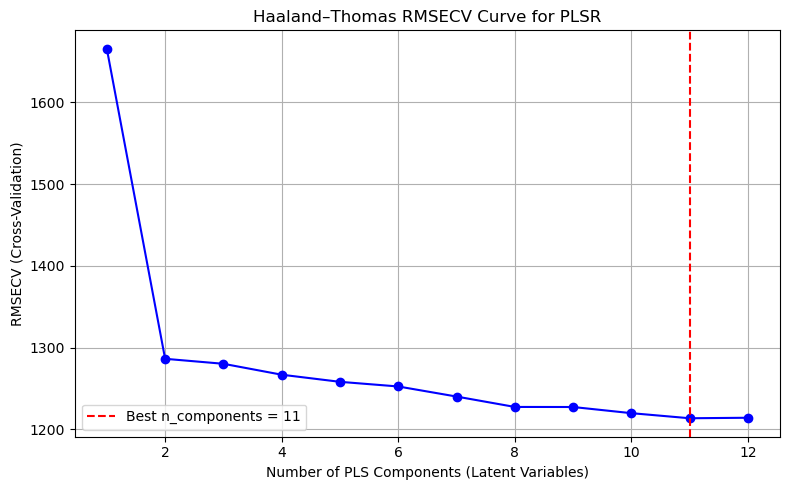

In [25]:
# Haaland–Thomas Style PLSR with Cross-Validation RMSE
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load dataset
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"
test_path  = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

target_column = "Yield"

X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test = test_df.drop(columns=[target_column]).values
y_test = test_df[target_column].values

# 2. Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

# 3. Define PLSR model
pls = PLSRegression(scale=False)

# 4. Define range of latent variables (components)
param_grid = {'n_components': list(range(1, min(12, X_train.shape[1]) + 1))}

# 5. Define cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# 6. GridSearchCV using negative MSE (Haaland–Thomas criterion = lowest RMSECV)
grid = GridSearchCV(
    estimator=pls,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 7. Fit grid search
print("\nRunning Haaland–Thomas PLSR...")
grid.fit(X_train_scaled, y_train)

# 8. Extract best model and parameters
best_ncomp = grid.best_params_['n_components']
best_pls = grid.best_estimator_
print(f"\nOptimal number of components (Haaland–Thomas): {best_ncomp}")
print(f"Best cross-validation RMSE: {np.sqrt(-grid.best_score_):.4f}")

# 9. Model evaluation (Train/Test)
y_pred_train = best_pls.predict(X_train_scaled).ravel()
y_pred_test  = best_pls.predict(X_test_scaled).ravel()

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)

print("\nModel Evaluation:")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test  R²   : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test  RMSE : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test  RPD  : {test_rpd:.4f}")

# 10. Plot RMSE vs number of components (Haaland–Thomas curve)
results = pd.DataFrame(grid.cv_results_)
results['RMSECV'] = np.sqrt(-results['mean_test_score'])

plt.figure(figsize=(8, 5))
plt.plot(results['param_n_components'], results['RMSECV'], marker='o', color='blue')
plt.axvline(best_ncomp, color='red', linestyle='--', label=f'Best n_components = {best_ncomp}')
plt.title("Haaland–Thomas RMSECV Curve for PLSR")
plt.xlabel("Number of PLS Components (Latent Variables)")
plt.ylabel("RMSECV (Cross-Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Section 4(RF)

Random Forest model saved as RF_model.pkl

Random Forest Model Evaluation:
Train R²   : 0.9611
Test R²    : 0.8199
Train RMSE : 412.4643
Test RMSE  : 888.7907
Train RPD  : 5.0703
Test RPD   : 2.3598


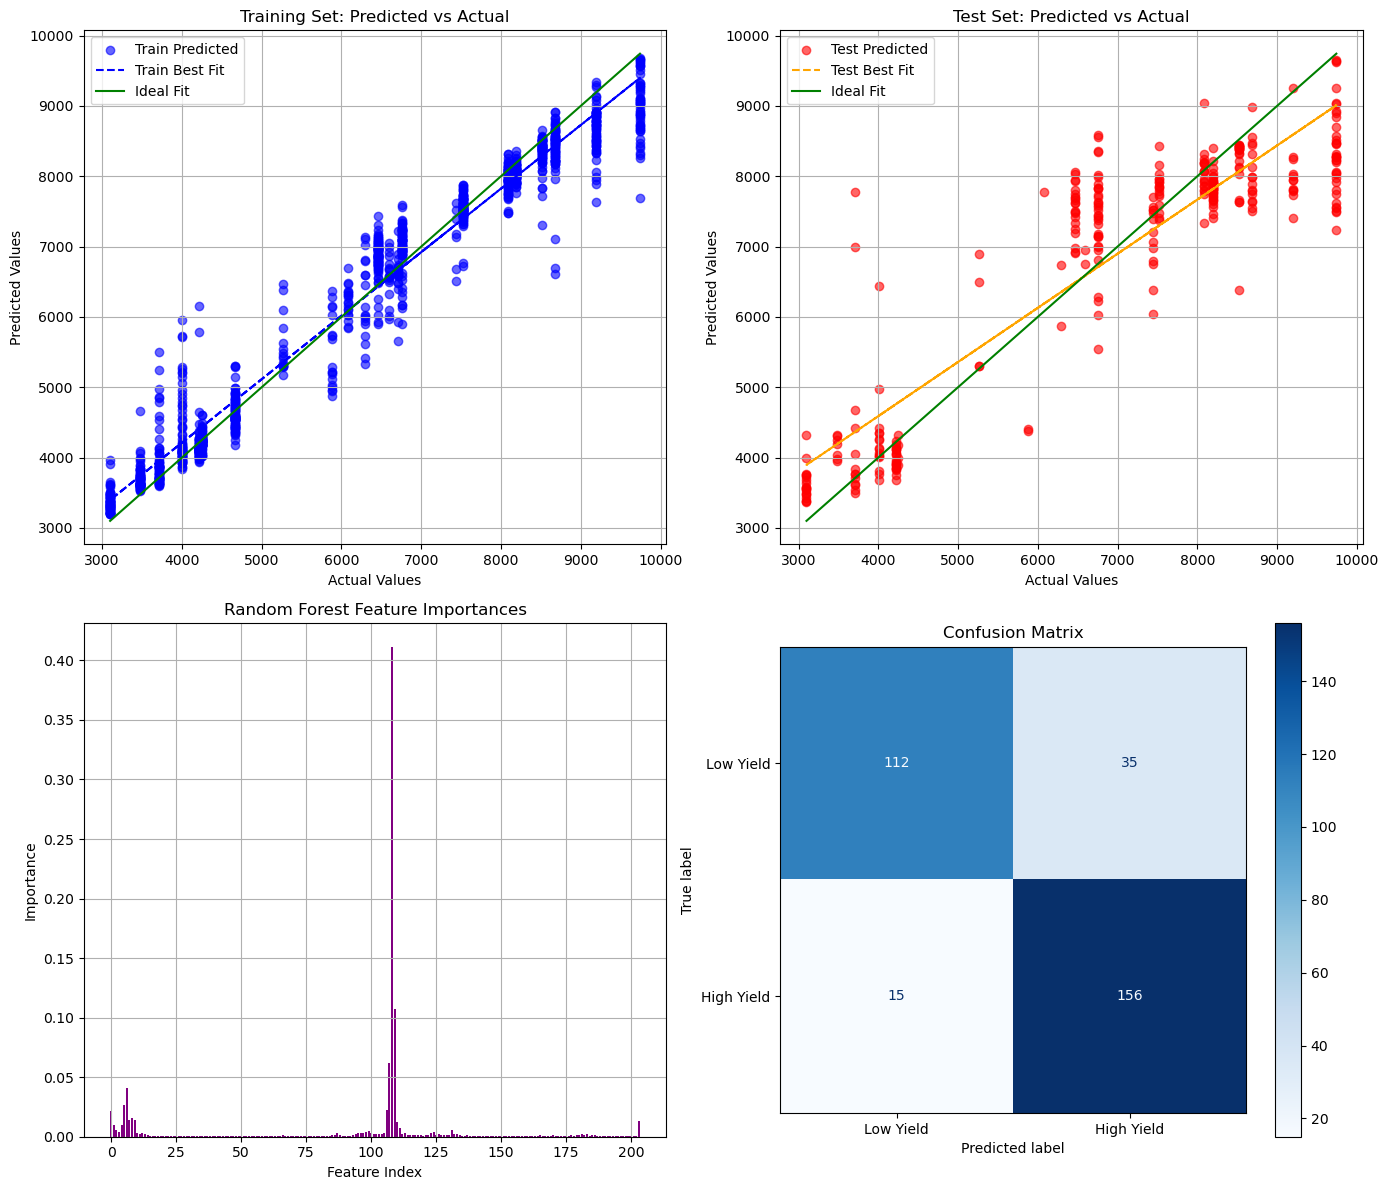

In [12]:
# Random Forest Regression
import pandas as pd                           # For handling CSV files and dataframes
import numpy as np                            # For numerical calculations
from sklearn.preprocessing import StandardScaler  # For scaling features to standard range
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay  # Metrics for evaluation
from sklearn.ensemble import RandomForestRegressor   # Random Forest Regressor model
import matplotlib.pyplot as plt               # For plotting graphs
import pickle                                 # For saving/loading model and scaler

# Load CSV files
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"  # Training dataset path
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"    # Testing dataset path

train_df = pd.read_csv(train_path)            # Read training CSV into DataFrame
test_df = pd.read_csv(test_path)              # Read testing CSV into DataFrame

# Features and target
target_column = "Yield"                       # The target column to predict is 'Yield'
X_train = train_df.drop(columns=[target_column]).values   # Training features (all columns except 'Yield')
y_train = train_df[target_column].values      # Training target (Yield values)
X_test = test_df.drop(columns=[target_column]).values     # Testing features
y_test = test_df[target_column].values        # Testing target

# Standardize features
scaler_X = StandardScaler()                   # Create a scaler to standardize features (mean=0, std=1)
X_train_scaled = scaler_X.fit_transform(X_train)    # Fit scaler on training data and transform it
X_test_scaled = scaler_X.transform(X_test)          # Use the same scaler to transform test data

# Save the scaler
with open("scaler_X.pkl", "wb") as f:         # Open file in write-binary mode
    pickle.dump(scaler_X, f)                  # Save the fitted scaler for future use

# Build and train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=400,       # Number of trees in the forest
    max_depth=20, 
    min_samples_split=2,    # Minimum samples required to split a node
    min_samples_leaf=2,           # Maximum depth of each tree (limits overfitting)
    random_state=42,        # Set seed for reproducibility
    n_jobs=-1               # Use all available CPU cores for faster training
)
rf_model.fit(X_train_scaled, y_train)         # Train the Random Forest model using scaled training data

# Save model
with open("RF_model.pkl", "wb") as f:         # Open file to save trained model
    pickle.dump(rf_model, f)                  # Save the trained Random Forest model
print("Random Forest model saved as RF_model.pkl")   # Print confirmation

# Load saved model and scaler
rf_loaded = pickle.load(open("RF_model.pkl", "rb"))        # Load the saved Random Forest model
scaler_loaded = pickle.load(open("scaler_X.pkl", "rb"))    # Load the saved scaler

# Scale test/train data using loaded scaler
X_train_scaled_loaded = scaler_loaded.transform(X_train)   # Scale train data again using loaded scaler
X_test_scaled_loaded = scaler_loaded.transform(X_test)     # Scale test data again using loaded scaler

# Predict
y_pred_train = rf_loaded.predict(X_train_scaled_loaded)    # Predict yields on training data
y_pred_test = rf_loaded.predict(X_test_scaled_loaded)      # Predict yields on testing data

# Evaluation function
def evaluate(y_true, y_pred):                               # Define a function for model evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))      # Calculate Root Mean Square Error
    r2 = r2_score(y_true, y_pred)                           # Calculate R² score (goodness of fit)
    rpd = np.std(y_true, ddof=1) / rmse                     # Calculate RPD (useful in agriculture)
    return r2, rmse, rpd                                    # Return the metrics

# Evaluate predictions
train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)  # Evaluate training data performance
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)       # Evaluate testing data performance

# Print results
print("\nRandom Forest Model Evaluation:")                 # Print header
print(f"Train R²   : {train_r2:.4f}")                       # Show R² for training data
print(f"Test R²    : {test_r2:.4f}")                        # Show R² for testing data
print(f"Train RMSE : {train_rmse:.4f}")                     # Show RMSE for training data
print(f"Test RMSE  : {test_rmse:.4f}")                       # Show RMSE for testing data
print(f"Train RPD  : {train_rpd:.4f}")                       # Show RPD for training data
print(f"Test RPD   : {test_rpd:.4f}")                         # Show RPD for testing data

# Plots (similar to CNN code)
fig, axes = plt.subplots(2, 2, figsize=(14,12))              # Create 2x2 grid of subplots

# Train scatter plot
axes[0,0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')    # Scatter plot for train data
z_train = np.polyfit(y_train, y_pred_train, 1)               # Fit a best-fit line for train data
p_train = np.poly1d(z_train)                                 # Create polynomial function
axes[0,0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")    # Plot best-fit line
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")  # Ideal diagonal line
axes[0,0].set_title("Training Set: Predicted vs Actual")     # Set title
axes[0,0].set_xlabel("Actual Values")                        # X-axis label
axes[0,0].set_ylabel("Predicted Values")                     # Y-axis label
axes[0,0].legend()                                           # Show legend
axes[0,0].grid(True)                                         # Add grid lines

# Test scatter plot
axes[0,1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')       # Scatter plot for test data
z_test = np.polyfit(y_test, y_pred_test, 1)                  # Fit a best-fit line for test data
p_test = np.poly1d(z_test)                                   # Create polynomial function
axes[0,1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")     # Plot best-fit line
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")      # Ideal diagonal line
axes[0,1].set_title("Test Set: Predicted vs Actual")         # Set title
axes[0,1].set_xlabel("Actual Values")                        # X-axis label
axes[0,1].set_ylabel("Predicted Values")                     # Y-axis label
axes[0,1].legend()                                           # Show legend
axes[0,1].grid(True)                                         # Add grid lines

# Feature importance plot
axes[1,0].bar(range(X_train.shape[1]), rf_loaded.feature_importances_, color='purple')      # Bar chart for feature importance
axes[1,0].set_title("Random Forest Feature Importances")     # Title of the chart
axes[1,0].set_xlabel("Feature Index")                         # X-axis label
axes[1,0].set_ylabel("Importance")                            # Y-axis label
axes[1,0].grid(True)                                          # Add grid lines

# Confusion matrix (convert regression output to classes)
y_test_class = (y_test >= np.median(y_test)).astype(int)      # Classify yields as High (1) or Low (0) based on median
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)  # Same for predictions
cm = confusion_matrix(y_test_class, y_pred_test_class)        # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"]) # Create display object
disp.plot(ax=axes[1,1], cmap=plt.cm.Blues, values_format="d")  # Plot confusion matrix with blue color map
axes[1,1].set_title("Confusion Matrix")                       # Set title

plt.tight_layout()                                             # Adjust layout to avoid overlap
plt.show()                                                     # Display all plots



 Starting RandomizedSearchCV...
Fitting 10 folds for each of 15 candidates, totalling 150 fits

 Best Parameters found:
{'n_estimators': 600, 'min_samples_split': 30, 'min_samples_leaf': 10, 'max_samples': 0.7, 'max_features': 0.3, 'max_depth': 5, 'bootstrap': True}
 Best R² Score from CV: 0.7262825009353984

 Best Random Forest model saved as RF_model_best.pkl

 Random Forest Model Evaluation:
Train R²   : 0.7808
Test R²    : 0.7309
Train RMSE : 978.8086
Test RMSE  : 1086.3676
Train RPD  : 2.1366
Test RPD   : 1.9307


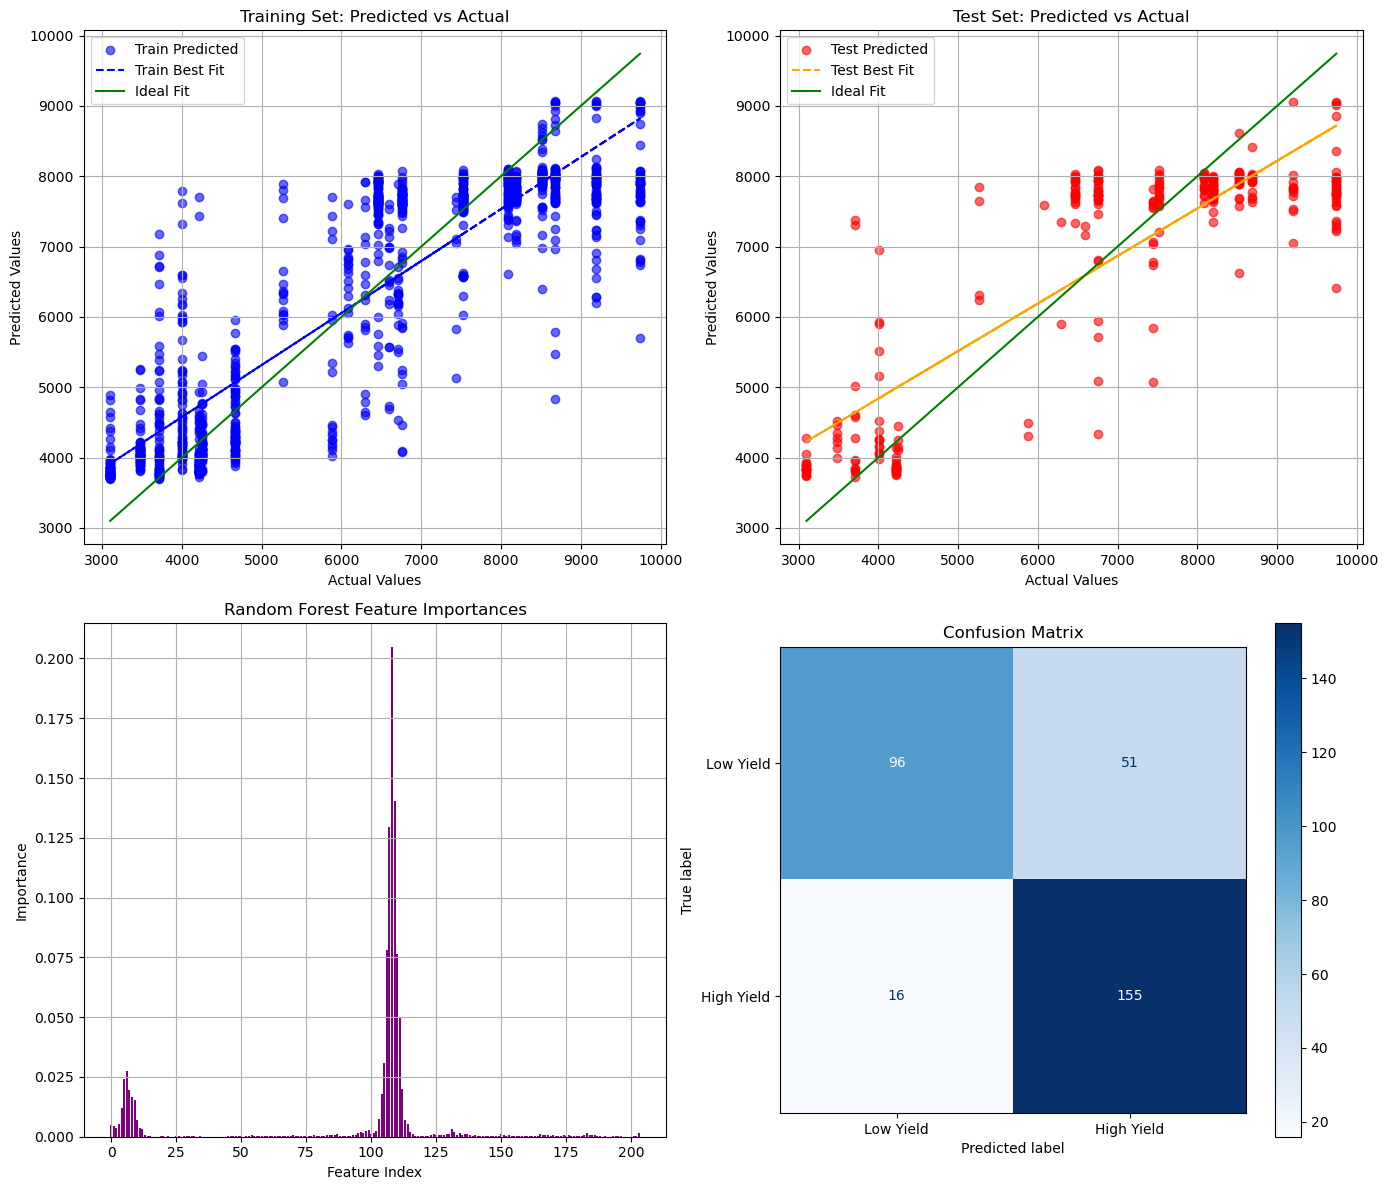

In [ ]:
# Random Forest Regression + RandomizedSearchCV
import pandas as pd  # For handling CSV files and DataFrames
import numpy as np  # For numerical operations like arrays and math
from sklearn.preprocessing import StandardScaler  # To standardize features (mean=0, std=1)
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay  # For evaluation
from sklearn.ensemble import RandomForestRegressor  # Random Forest model
from sklearn.model_selection import RandomizedSearchCV  # Hyperparameter tuning using randomized search
from scipy.stats import randint  # To define random integer distributions for hyperparameters
import matplotlib.pyplot as plt  # For plotting graphs
import pickle  # To save/load trained models or scalers

# 1. Load CSV files
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"  # Path to training CSV
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"    # Path to testing CSV

train_df = pd.read_csv(train_path)  # Load training data into DataFrame
test_df = pd.read_csv(test_path)    # Load testing data into DataFrame

# 2. Features and target
target_column = "Yield"  # Column we want to predict
X_train = train_df.drop(columns=[target_column]).values  # Training features (all columns except target)
y_train = train_df[target_column].values  # Training target values
X_test = test_df.drop(columns=[target_column]).values  # Testing features
y_test = test_df[target_column].values  # Testing target values

# 3. Standardize features
scaler_X = StandardScaler()  # Initialize scaler
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit on training data and transform
X_test_scaled = scaler_X.transform(X_test)  # Transform test data using same scaler

with open("scaler_X.pkl", "wb") as f:  # Save scaler for future use
    pickle.dump(scaler_X, f)

# 4. Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [400, 500, 600],      # Number of trees; more → stable but slower
    'max_depth': [3, 4, 5],               # Max depth of trees; lower → less overfitting
    'min_samples_split': [20, 25, 30, 35, 40], # Min samples to split a node; higher → more regularization
    'min_samples_leaf': [8, 10, 12, 15], # Min samples at leaf; prevents tiny leaves
    'max_features': [0.3, 0.4, 0.5],     # Fraction of features per split; lower → more randomness
    'bootstrap': [True],                  # Use bootstrap sampling
    'max_samples': [0.7]                  # Fraction of samples per tree
}

rf_model = RandomForestRegressor(random_state=42)  # Base RF model with reproducibility

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=15,          # Slightly more combinations to explore
    scoring='r2',
    cv=10,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("\n Starting RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train)  # Run randomized search and fit on training data

print("\n Best Parameters found:")
print(random_search.best_params_)  # Print best hyperparameters
print(" Best R² Score from CV:", random_search.best_score_)  # Print best cross-validated R² score

best_rf = random_search.best_estimator_  # Extract the best model

# 5. Save the Best Model
with open("RF_model_best.pkl", "wb") as f:  # Open file to save model
    pickle.dump(best_rf, f)  # Save the trained model
print("\n Best Random Forest model saved as RF_model_best.pkl")

# 6. Predictions
y_pred_train = best_rf.predict(X_train_scaled)  # Predict on training data
y_pred_test = best_rf.predict(X_test_scaled)  # Predict on test data

# 7. Evaluation Function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Compute RMSE
    r2 = r2_score(y_true, y_pred)  # Compute R²
    rpd = np.std(y_true, ddof=1) / rmse  # Compute RPD
    return r2, rmse, rpd  # Return metrics

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)  # Evaluate training predictions
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)  # Evaluate testing predictions

print("\n Random Forest Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")  # Training R²
print(f"Test R²    : {test_r2:.4f}")  # Testing R²
print(f"Train RMSE : {train_rmse:.4f}")  # Training RMSE
print(f"Test RMSE  : {test_rmse:.4f}")  # Testing RMSE
print(f"Train RPD  : {train_rpd:.4f}")  # Training RPD
print(f"Test RPD   : {test_rpd:.4f}")  # Testing RPD

# 8. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Create 2x2 subplot grid

# Train Scatter Plot
axes[0, 0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')  # Scatter plot
z_train = np.polyfit(y_train, y_pred_train, 1)  # Fit line to training predictions
p_train = np.poly1d(z_train)  # Polynomial for best-fit line
axes[0, 0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")  # Plot best-fit
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")  # Ideal diagonal
axes[0, 0].set_title("Training Set: Predicted vs Actual")  # Title
axes[0, 0].set_xlabel("Actual Values")  # X-axis label
axes[0, 0].set_ylabel("Predicted Values")  # Y-axis label
axes[0, 0].legend()  # Show legend
axes[0, 0].grid(True)  # Show grid

# Test Scatter Plot
axes[0, 1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')  # Scatter plot
z_test = np.polyfit(y_test, y_pred_test, 1)  # Fit line to test predictions
p_test = np.poly1d(z_test)  # Polynomial for best-fit
axes[0, 1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")  # Best-fit line
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")  # Ideal diagonal
axes[0, 1].set_title("Test Set: Predicted vs Actual")  # Title
axes[0, 1].set_xlabel("Actual Values")  # X-axis label
axes[0, 1].set_ylabel("Predicted Values")  # Y-axis label
axes[0, 1].legend()  # Show legend
axes[0, 1].grid(True)  # Show grid

# Feature Importance Plot
axes[1, 0].bar(range(X_train.shape[1]), best_rf.feature_importances_, color='purple')  # Bar plot for feature importance
axes[1, 0].set_title("Random Forest Feature Importances")  # Title
axes[1, 0].set_xlabel("Feature Index")  # X-axis label
axes[1, 0].set_ylabel("Importance")  # Y-axis label
axes[1, 0].grid(True)  # Show grid

# Confusion Matrix
y_test_class = (y_test >= np.median(y_test)).astype(int)  # Convert true values to High/Low classes
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)  # Convert predicted values to classes
cm = confusion_matrix(y_test_class, y_pred_test_class)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])  # Prepare display
disp.plot(ax=axes[1, 1], cmap=plt.cm.Blues, values_format="d")  # Plot confusion matrix
axes[1, 1].set_title("Confusion Matrix")  # Title

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display all plots


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 0.4, 'max_samples': 0.8, 'min_samples_leaf': 8, 'min_samples_split': 25, 'n_estimators': 550}
Random Forest model with Grid Search saved as RF_model_grid.pkl

Random Forest Model Evaluation:
Train R²   : 0.8075
Test R²    : 0.7448
Train RMSE : 917.2299
Test RMSE  : 1057.9566
Train RPD  : 2.2800
Test RPD   : 1.9825


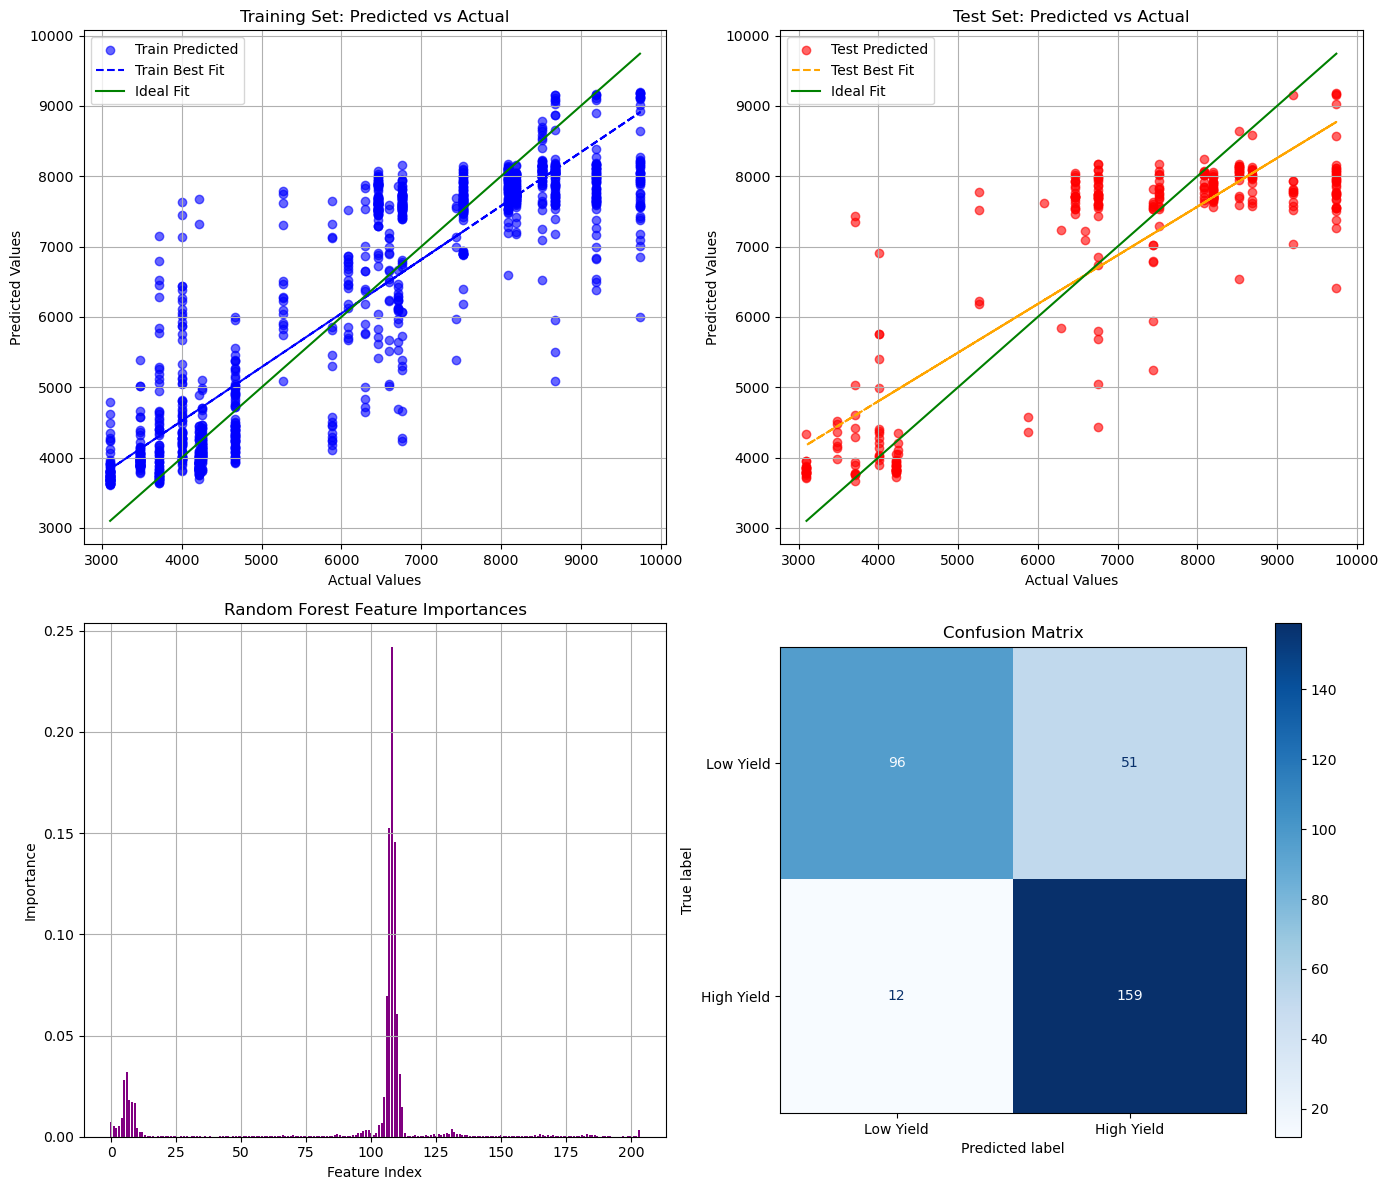

In [ ]:
# Random Forest Regression + Grid Search CV
import pandas as pd  # Import pandas for reading CSV files and handling dataframes
import numpy as np  # Import numpy for numerical operations like arrays and calculations
from sklearn.preprocessing import StandardScaler  # For standardizing features to mean=0, std=1
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay  # For evaluation metrics
from sklearn.ensemble import RandomForestRegressor  # Random Forest regression model
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning using Grid Search
import matplotlib.pyplot as plt  # For plotting graphs
import pickle  # For saving/loading models and scalers

# 1. Load CSV files
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"  # Path to training dataset CSV
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"  # Path to testing dataset CSV

train_df = pd.read_csv(train_path)  # Load training CSV into pandas DataFrame
test_df = pd.read_csv(test_path)  # Load testing CSV into pandas DataFrame

# 2. Features and target
target_column = "Yield"  # Define the target variable column name
X_train = train_df.drop(columns=[target_column]).values  # Drop target column to get training features as numpy array
y_train = train_df[target_column].values  # Get training target values as numpy array
X_test = test_df.drop(columns=[target_column]).values  # Drop target column to get testing features
y_test = test_df[target_column].values  # Get testing target values

# 3. Standardize features
scaler_X = StandardScaler()  # Create a StandardScaler object
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit scaler on training data and transform it
X_test_scaled = scaler_X.transform(X_test)  # Transform testing data using the same scaler

# Save the scaler to file for later use
with open("scaler_X.pkl", "wb") as f:  # Open file in write-binary mode
    pickle.dump(scaler_X, f)  # Save the fitted scaler object

# 4. Grid Search for Random Forest
param_grid = {
    'n_estimators': [550, 600, 650],      # Number of trees; more → stable but slower
    'max_depth': [4, 5, 6],               # Max depth of trees; controls complexity
    'min_samples_split': [25, 30, 35],   # Min samples to split a node; higher → more regularization
    'min_samples_leaf': [8, 10, 12],     # Min samples at leaf; prevents tiny leaves
    'max_features': [0.3, 0.4],          # Fraction of features per split; lower → more randomness
    'bootstrap': [True],                  # Use bootstrap sampling
    'max_samples': [0.7, 0.8]            # Fraction of samples per tree if bootstrap=True
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)  # Create a base Random Forest Regressor with all CPU cores

grid_search = GridSearchCV(
    estimator=rf,  # Model to tune
    param_grid=param_grid,  # Hyperparameter grid to search
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R² as evaluation metric
    n_jobs=-1,  # Use all CPU cores for parallel computation
    verbose=2  # Print progress messages
)

grid_search.fit(X_train_scaled, y_train)  # Fit Grid Search on training data
best_rf_model = grid_search.best_estimator_  # Retrieve the best model from Grid Search
print("Best Hyperparameters:", grid_search.best_params_)  # Print best hyperparameters

# Save the best Grid Search model
with open("RF_model_grid.pkl", "wb") as f:  # Open file to save model
    pickle.dump(best_rf_model, f)  # Save best Random Forest model
print("Random Forest model with Grid Search saved as RF_model_grid.pkl")  # Print confirmation

# 5. Load saved model and scaler
rf_loaded = pickle.load(open("RF_model_grid.pkl", "rb"))  # Load trained Random Forest model
scaler_loaded = pickle.load(open("scaler_X.pkl", "rb"))  # Load saved scaler

# Scale train/test data using loaded scaler
X_train_scaled_loaded = scaler_loaded.transform(X_train)  # Transform training features
X_test_scaled_loaded = scaler_loaded.transform(X_test)  # Transform testing features

# 6. Predictions
y_pred_train = rf_loaded.predict(X_train_scaled_loaded)  # Predict target on training data
y_pred_test = rf_loaded.predict(X_test_scaled_loaded)  # Predict target on testing data

# 7. Evaluation Function
def evaluate(y_true, y_pred):  # Define function to calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Calculate Root Mean Square Error
    r2 = r2_score(y_true, y_pred)  # Calculate R² score
    rpd = np.std(y_true, ddof=1) / rmse  # Calculate RPD (ratio of SD to RMSE)
    return r2, rmse, rpd  # Return metrics

# Evaluate predictions for training and testing data
train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)  # Training metrics
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)  # Testing metrics

# Print evaluation results
print("\nRandom Forest Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")  # R² for training
print(f"Test R²    : {test_r2:.4f}")  # R² for testing
print(f"Train RMSE : {train_rmse:.4f}")  # RMSE for training
print(f"Test RMSE  : {test_rmse:.4f}")  # RMSE for testing
print(f"Train RPD  : {train_rpd:.4f}")  # RPD for training
print(f"Test RPD   : {test_rpd:.4f}")  # RPD for testing

# 8. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14,12))  # Create 2x2 subplot grid

# Training scatter plot
axes[0,0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')  # Plot predicted vs actual
z_train = np.polyfit(y_train, y_pred_train, 1)  # Fit linear regression line
p_train = np.poly1d(z_train)  # Create polynomial function for line
axes[0,0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")  # Plot best-fit line
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")  # Plot perfect fit line
axes[0,0].set_title("Training Set: Predicted vs Actual")  # Set title
axes[0,0].set_xlabel("Actual Values")  # X-axis label
axes[0,0].set_ylabel("Predicted Values")  # Y-axis label
axes[0,0].legend()  # Show legend
axes[0,0].grid(True)  # Show grid

# Testing scatter plot
axes[0,1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')  # Plot predicted vs actual
z_test = np.polyfit(y_test, y_pred_test, 1)  # Fit linear regression line
p_test = np.poly1d(z_test)  # Create polynomial function
axes[0,1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")  # Best-fit line
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")  # Perfect line
axes[0,1].set_title("Test Set: Predicted vs Actual")  # Set title
axes[0,1].set_xlabel("Actual Values")  # X-axis label
axes[0,1].set_ylabel("Predicted Values")  # Y-axis label
axes[0,1].legend()  # Show legend
axes[0,1].grid(True)  # Show grid

# Feature importance bar chart
axes[1,0].bar(range(X_train.shape[1]), rf_loaded.feature_importances_, color='purple')  # Bar chart of feature importances
axes[1,0].set_title("Random Forest Feature Importances")  # Title
axes[1,0].set_xlabel("Feature Index")  # X-axis label
axes[1,0].set_ylabel("Importance")  # Y-axis label
axes[1,0].grid(True)  # Show grid

# Confusion matrix
y_test_class = (y_test >= np.median(y_test)).astype(int)  # Convert actual values to binary classes
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)  # Convert predictions to binary classes
cm = confusion_matrix(y_test_class, y_pred_test_class)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])  # Prepare display
disp.plot(ax=axes[1,1], cmap=plt.cm.Blues, values_format="d")  # Plot confusion matrix
axes[1,1].set_title("Confusion Matrix")  # Set title

plt.tight_layout()  # Adjust subplot layout
plt.show()  # Show plots


Section 5(CNN-1D)

Epoch 1/100


c:\Users\Abu Jubayer\.conda\envs\tf_gpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 35288524.0000 - mae: 5544.3257 - val_loss: 46470148.0000 - val_mae: 6504.0410
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9371094.0000 - mae: 2437.3701 - val_loss: 27880186.0000 - val_mae: 4885.0547
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2929778.0000 - mae: 1382.8396 - val_loss: 29202484.0000 - val_mae: 5050.8306
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2327455.5000 - mae: 1206.5682 - val_loss: 29503892.0000 - val_mae: 5113.4658
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2314961.2500 - mae: 1196.4432 - val_loss: 27221204.0000 - val_mae: 4925.0381
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1987050.8750 - mae: 1110.0874 - val_loss: 30209700.0000 - val_mae: 5238.6362
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1852973.2500 - mae: 1065.1010 - val_loss: 26668270.0000 - val_mae: 4912.8647
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

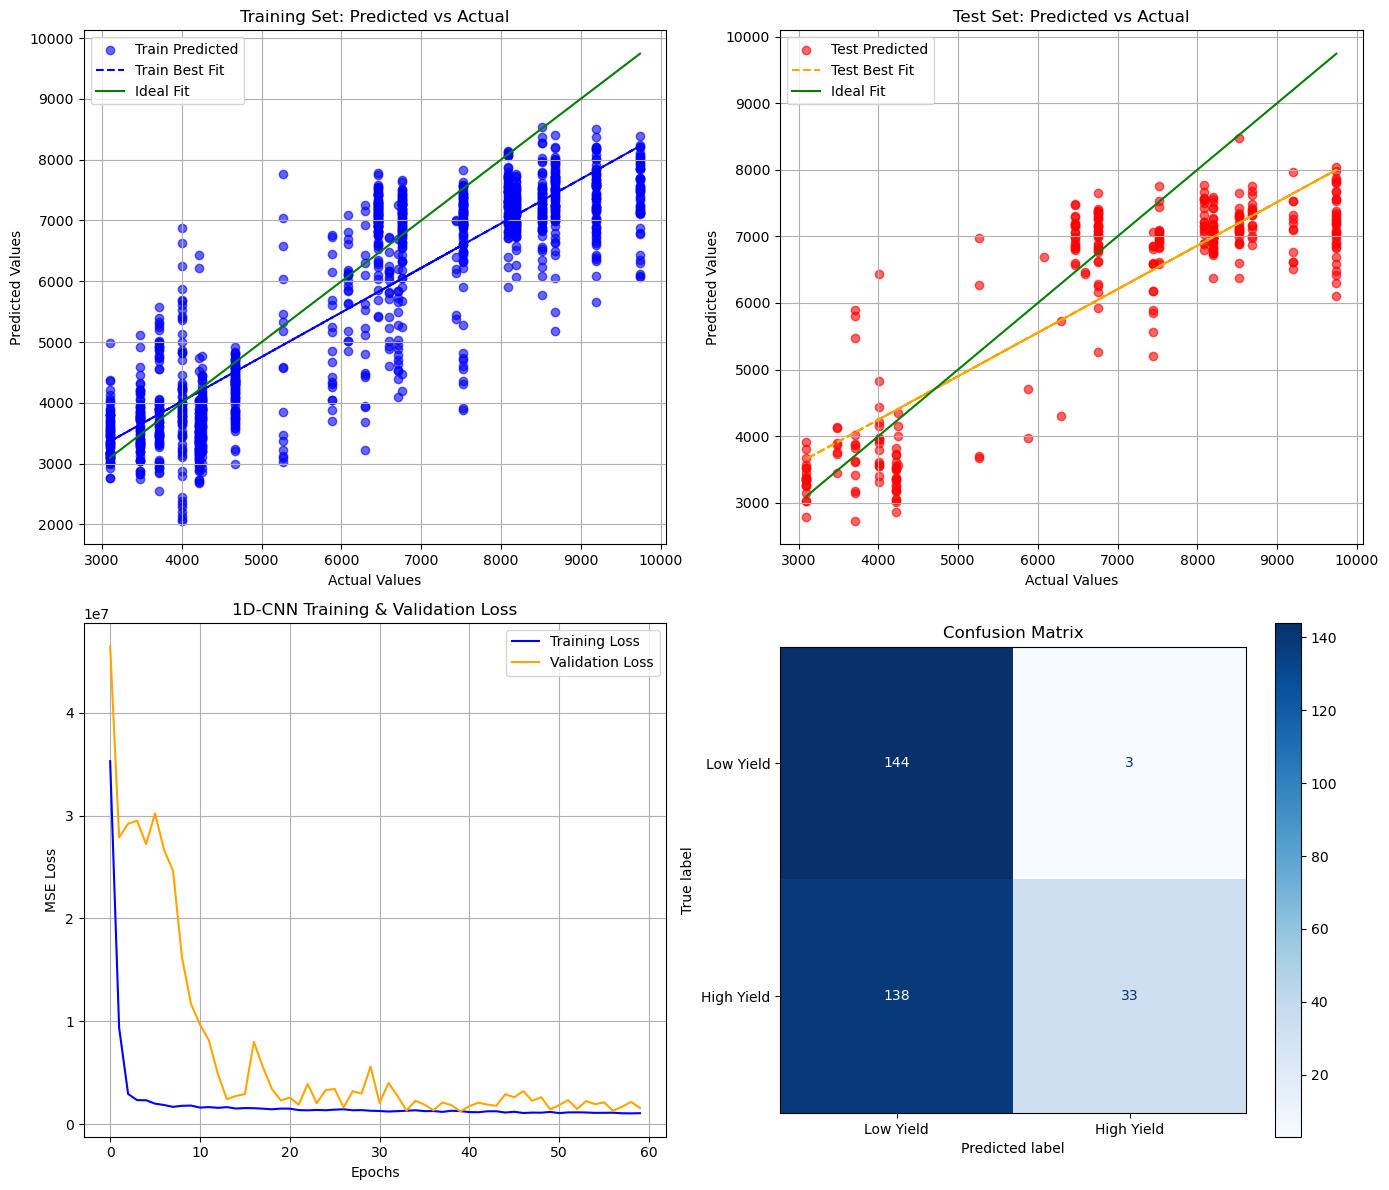

In [14]:
# CNN-1D (Convolutional Neural Network – One Dimensional)
import pandas as pd                                      # For handling CSV files and tabular data
import numpy as np                                       # For numerical operations
from sklearn.preprocessing import StandardScaler         # For feature standardization
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay  # Evaluation metrics
import matplotlib.pyplot as plt                           # For plotting
from tensorflow.keras.models import Sequential, load_model  # Build and load Keras models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization  # CNN layers
from tensorflow.keras.callbacks import EarlyStopping     # Early stopping during training
import pickle                                           # For saving and loading scaler objects

# Load CSV files containing KS-split data
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"  # Path to training data
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"    # Path to test data

train_df = pd.read_csv(train_path)                       # Load training data into a DataFrame
test_df = pd.read_csv(test_path)                         # Load test data into a DataFrame

# Define features (X) and target (y)
target_column = "Yield"                                  # Target column to predict
X_train = train_df.drop(columns=[target_column]).values  # Extract features from training set
y_train = train_df[target_column].values                 # Extract target values from training set
X_test = test_df.drop(columns=[target_column]).values    # Extract features from test set
y_test = test_df[target_column].values                   # Extract target values from test set

# Standardize features to zero mean and unit variance
scaler_X = StandardScaler()                               # Initialize StandardScaler
X_train_scaled = scaler_X.fit_transform(X_train)          # Fit on training data and transform
X_test_scaled = scaler_X.transform(X_test)                # Transform test data with same scaler

# Save the scaler object for later reuse
with open("scaler_X.pkl", "wb") as f:                     # Open file to save scaler
    pickle.dump(scaler_X, f)                              # Save scaler object

# Reshape data for 1D-CNN input: (samples, timesteps, features=1)
X_train_scaled = X_train_scaled[..., np.newaxis]          # Add extra dimension for CNN input
X_test_scaled = X_test_scaled[..., np.newaxis]            # Add extra dimension for CNN input

# Build 1D-CNN model using Keras Sequential API
model = Sequential([                                      # Initialize sequential model
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1],1)),  # Conv layer with 64 filters
    BatchNormalization(),                                 # Normalize activations
    MaxPooling1D(pool_size=2),                            # Downsample by factor of 2
    Dropout(0.2),                                         # Dropout for regularization

    Conv1D(128, kernel_size=3, activation='relu'),       # Second Conv layer with 128 filters
    BatchNormalization(),                                 # Normalize activations
    MaxPooling1D(pool_size=2),                            # Downsample
    Dropout(0.2),                                         # Dropout

    Flatten(),                                            # Flatten output to feed Dense layers
    Dense(128, activation='relu'),                        # Fully connected Dense layer
    Dropout(0.2),                                         # Dropout
    Dense(1, activation='linear')                         # Output layer for regression
])

# Compile model with optimizer and loss function
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use Adam optimizer and MSE loss
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Stop if val_loss doesn't improve

# Train the model
history = model.fit(
    X_train_scaled, y_train,           # Training features and target
    epochs=100,                        # Maximum number of epochs
    batch_size=16,                     # Batch size
    validation_split=0.2,              # Use 20% of training data as validation
    verbose=1,                         # Show progress
    callbacks=[early_stop]             # Early stopping callback
)

# Save final trained model
model.save("CNN1D_final_model.keras") # Save model for reuse
print("Model saved as CNN1D_final_model.keras")  # Print confirmation

# Reuse saved model
model_loaded = load_model("CNN1D_final_model.keras")  # Load saved model
scaler_loaded = pickle.load(open("scaler_X.pkl", "rb"))  # Load saved scaler

# Apply scaler and reshape data for prediction
X_train_scaled_loaded = scaler_loaded.transform(X_train)[..., np.newaxis]  # Scale and reshape training data
X_test_scaled_loaded = scaler_loaded.transform(X_test)[..., np.newaxis]    # Scale and reshape test data

# Predict target values
y_pred_train = model_loaded.predict(X_train_scaled_loaded).flatten()  # Training predictions
y_pred_test = model_loaded.predict(X_test_scaled_loaded).flatten()    # Test predictions

# Function to evaluate predictions
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Compute RMSE
    r2 = r2_score(y_true, y_pred)                       # Compute R² score
    rpd = np.std(y_true, ddof=1) / rmse                # Compute RPD (Ratio of Performance to Deviation)
    return r2, rmse, rpd                                # Return metrics

# Evaluate train and test predictions
train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)  # Train metrics
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)       # Test metrics

# Print evaluation results
print("\nLoaded 1D-CNN Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")        # Print R² for training
print(f"Test R²    : {test_r2:.4f}")         # Print R² for testing
print(f"Train RMSE : {train_rmse:.4f}")      # Print RMSE for training
print(f"Test RMSE  : {test_rmse:.4f}")       # Print RMSE for testing
print(f"Train RPD  : {train_rpd:.4f}")       # Print RPD for training
print(f"Test RPD   : {test_rpd:.4f}")        # Print RPD for testing

# Create 2x2 grid plots for visualization
fig, axes = plt.subplots(2, 2, figsize=(14,12))  # Create figure with 2x2 subplots

# 1. Train scatter plot: predicted vs actual
axes[0,0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')  # Scatter plot
z_train = np.polyfit(y_train, y_pred_train, 1)      # Fit line for predictions
p_train = np.poly1d(z_train)
axes[0,0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")  # Plot best fit line
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")  # Ideal y=x line
axes[0,0].set_title("Training Set: Predicted vs Actual")  # Set title
axes[0,0].set_xlabel("Actual Values")                     # X-axis label
axes[0,0].set_ylabel("Predicted Values")                  # Y-axis label
axes[0,0].legend()                                        # Show legend
axes[0,0].grid(True)                                      # Show grid

# 2. Test scatter plot: predicted vs actual
axes[0,1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')      # Scatter plot
z_test = np.polyfit(y_test, y_pred_test, 1)       # Fit line
p_test = np.poly1d(z_test)
axes[0,1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")    # Best fit line
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")  # Ideal line
axes[0,1].set_title("Test Set: Predicted vs Actual")  # Title
axes[0,1].set_xlabel("Actual Values")                 # X label
axes[0,1].set_ylabel("Predicted Values")              # Y label
axes[0,1].legend()                                    # Legend
axes[0,1].grid(True)                                  # Grid

# 3. Training & validation loss over epochs
axes[1,0].plot(history.history['loss'], label='Training Loss', color='blue')  # Training loss plot
axes[1,0].plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Validation loss
axes[1,0].set_title("1D-CNN Training & Validation Loss")   # Title
axes[1,0].set_xlabel("Epochs")                              # X-axis label
axes[1,0].set_ylabel("MSE Loss")                             # Y-axis label
axes[1,0].legend()                                           # Legend
axes[1,0].grid(True)                                         # Grid

# 4. Confusion matrix for regression-as-classification
y_test_class = (y_test >= np.median(y_test)).astype(int)          # Convert regression target to binary
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)  # Convert predictions
cm = confusion_matrix(y_test_class, y_pred_test_class)            # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])  # Display
disp.plot(ax=axes[1,1], cmap=plt.cm.Blues, values_format="d")     # Plot confusion matrix
axes[1,1].set_title("Confusion Matrix")                            # Set title

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()          # Show all plots


Reloading Tuner from cnn_bayes_tuning\leaf_yield_tuning\tuner0.json

✅ Best Hyperparameters found:
filters_1: 32
kernel_size_1: 7
dropout_1: 0.2
filters_2: 192
kernel_size_2: 3
dropout_2: 0.4
dense_units: 128
dropout_dense: 0.30000000000000004
lr: 0.001
Epoch 1/100


c:\Users\Abu Jubayer\.conda\envs\tf_gpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 37836376.0000 - mae: 5785.4434 - val_loss: 48277748.0000 - val_mae: 6637.8467
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 21084886.0000 - mae: 4062.5640 - val_loss: 42446740.0000 - val_mae: 6184.3506
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5704453.0000 - mae: 1896.2178 - val_loss: 35151224.0000 - val_mae: 5567.4771
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2997297.2500 - mae: 1394.9427 - val_loss: 35846456.0000 - val_mae: 5638.0088
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2547525.5000 - mae: 1285.2688 - val_loss: 35804652.0000 - val_mae: 5648.5474
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2032915.3750 - mae: 1110.7623 - val_loss: 37055060.0000 - val_mae: 5768.6348
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1982416.1250 - mae: 1098.4912 - val_loss: 35946504.0000 - val_mae: 5688.9048
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

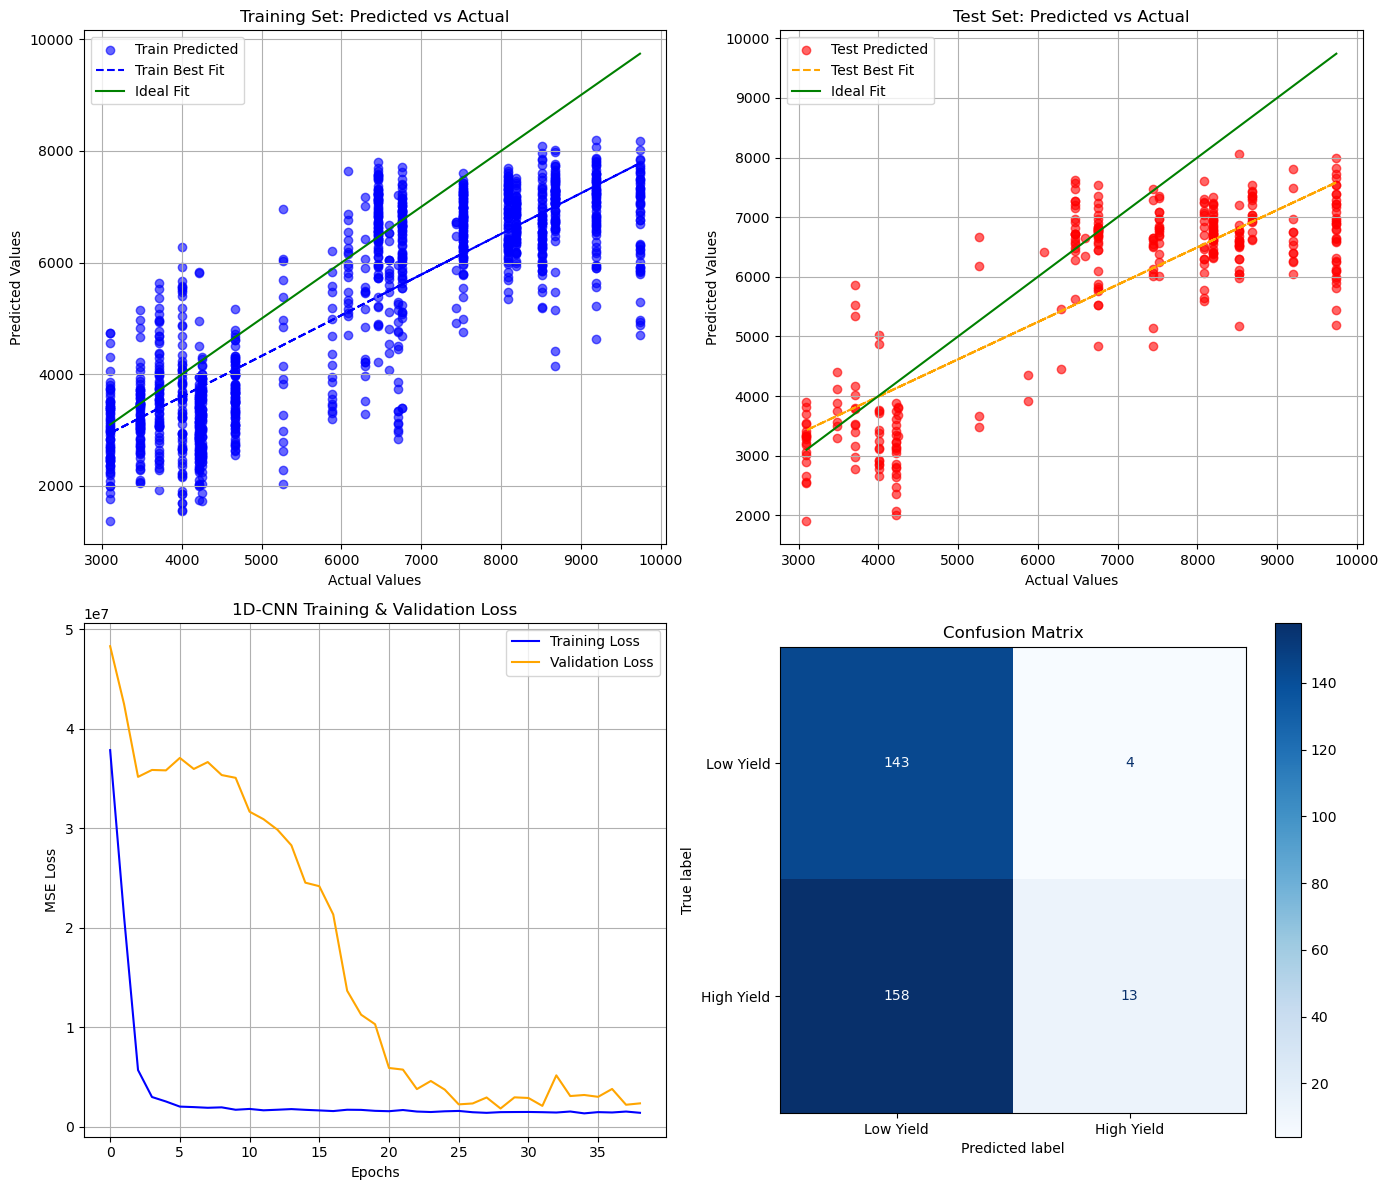

In [17]:
# ===============================================================
# CNN-1D (1D Convolutional Neural Network) with Bayesian Hyperparameter Tuning
# ===============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import keras_tuner as kt  # Keras Tuner

# =========================
# Load data
# =========================
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

target_column = "Yield"
X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test = test_df.drop(columns=[target_column]).values
y_test = test_df[target_column].values

# =========================
# Standardize features
# =========================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# Reshape for CNN
X_train_scaled = X_train_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

# =========================
# Define model builder for Keras Tuner
# =========================
def build_cnn_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size_1', [3,5,7]),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Conv1D(
        filters=hp.Int('filters_2', 64, 256, step=64),
        kernel_size=hp.Choice('kernel_size_2', [3,5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(
        hp.Int('dense_units', 64, 256, step=64),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4, 1e-5])),
        loss='mse',
        metrics=['mae']
    )
    return model

# =========================
# Keras Tuner: Bayesian Optimization
# =========================
tuner = kt.BayesianOptimization(
    build_cnn_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='cnn_bayes_tuning',
    project_name='leaf_yield_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run search
tuner.search(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best Hyperparameters found:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

# Build and train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Save final model
model.save("CNN1D_final_model.keras")
print("Model saved as CNN1D_final_model.keras")

# =========================
# Evaluation
# =========================
model_loaded = load_model("CNN1D_final_model.keras")
scaler_loaded = pickle.load(open("scaler_X.pkl", "rb"))

X_train_scaled_loaded = scaler_loaded.transform(X_train)[..., np.newaxis]
X_test_scaled_loaded = scaler_loaded.transform(X_test)[..., np.newaxis]

y_pred_train = model_loaded.predict(X_train_scaled_loaded).flatten()
y_pred_test = model_loaded.predict(X_test_scaled_loaded).flatten()

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)

print("\nLoaded 1D-CNN Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test RPD   : {test_rpd:.4f}")

# =========================
# 2x2 Plots
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# 1. Train
axes[0,0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')
z_train = np.polyfit(y_train, y_pred_train, 1)
p_train = np.poly1d(z_train)
axes[0,0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")
axes[0,0].set_title("Training Set: Predicted vs Actual")
axes[0,0].set_xlabel("Actual Values")
axes[0,0].set_ylabel("Predicted Values")
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Test
axes[0,1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')
z_test = np.polyfit(y_test, y_pred_test, 1)
p_test = np.poly1d(z_test)
axes[0,1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")
axes[0,1].set_title("Test Set: Predicted vs Actual")
axes[0,1].set_xlabel("Actual Values")
axes[0,1].set_ylabel("Predicted Values")
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Training & Validation Loss
axes[1,0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1,0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1,0].set_title("1D-CNN Training & Validation Loss")
axes[1,0].set_xlabel("Epochs")
axes[1,0].set_ylabel("MSE Loss")
axes[1,0].legend()
axes[1,0].grid(True)

# 4. Confusion matrix
y_test_class = (y_test >= np.median(y_test)).astype(int)
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)
cm = confusion_matrix(y_test_class, y_pred_test_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])
disp.plot(ax=axes[1,1], cmap=plt.cm.Blues, values_format="d")
axes[1,1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()


In [1]:
# ===============================================================
# CNN-1D (1D Convolutional Neural Network) with Improved Bayesian Hyperparameter Tuning
# ===============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import keras_tuner as kt  # Keras Tuner

# =========================
# Load data
# =========================
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

target_column = "Yield"
X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test = test_df.drop(columns=[target_column]).values
y_test = test_df[target_column].values

# =========================
# Standardize features
# =========================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# Reshape for CNN
X_train_scaled = X_train_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

# =========================
# Define model builder for Keras Tuner (Improved CNN)
# =========================
def build_cnn_model(hp):
    model = Sequential()

    # 1st Conv Block
    model.add(Conv1D(
        filters=hp.Int('filters_1', 64, 128, step=32),
        kernel_size=hp.Choice('kernel_size_1', [3, 5]),
        activation='relu',
        input_shape=(X_train_scaled.shape[1], 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.3, step=0.05)))

    # 2nd Conv Block
    model.add(Conv1D(
        filters=hp.Int('filters_2', 128, 256, step=64),
        kernel_size=hp.Choice('kernel_size_2', [3, 5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.3, step=0.05)))

    # 3rd Conv Block (new)
    model.add(Conv1D(
        filters=hp.Int('filters_3', 128, 256, step=64),
        kernel_size=hp.Choice('kernel_size_3', [3, 5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.3, step=0.05)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(
        hp.Int('dense_units', 128, 512, step=128),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.1, 0.3, step=0.05)))
    model.add(Dense(1, activation='linear'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

# =========================
# Keras Tuner: Bayesian Optimization
# =========================
tuner = kt.BayesianOptimization(
    build_cnn_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='cnn_bayes_tuning_improved',
    project_name='leaf_yield_tuning_v2'
)

stop_early = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Run search
tuner.search(
    X_train_scaled, y_train,
    epochs=150,
    validation_split=0.2,
    callbacks=[stop_early, reduce_lr],
    verbose=1,
    batch_size=32  # Default; tuner can override if added as hp parameter
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters found:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

# Build and train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train_scaled, y_train,
    epochs=150,
    validation_split=0.2,
    callbacks=[stop_early, reduce_lr],
    verbose=1,
    batch_size=best_hps.get('batch_size', 32)
)

# Save final model
model.save("CNN1D_final_model_improved.keras")
print("Model saved as CNN1D_final_model_improved.keras")

# =========================
# Evaluation
# =========================
model_loaded = load_model("CNN1D_final_model_improved.keras")
scaler_loaded = pickle.load(open("scaler_X.pkl", "rb"))

X_train_scaled_loaded = scaler_loaded.transform(X_train)[..., np.newaxis]
X_test_scaled_loaded = scaler_loaded.transform(X_test)[..., np.newaxis]

y_pred_train = model_loaded.predict(X_train_scaled_loaded).flatten()
y_pred_test = model_loaded.predict(X_test_scaled_loaded).flatten()

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)

print("\nLoaded 1D-CNN Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test RPD   : {test_rpd:.4f}")

# =========================
# Visualization
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# 1. Train
axes[0,0].scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train Predicted')
z_train = np.polyfit(y_train, y_pred_train, 1)
p_train = np.poly1d(z_train)
axes[0,0].plot(y_train, p_train(y_train), "blue", linestyle='--', label="Train Best Fit")
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "green", linestyle='-', label="Ideal Fit")
axes[0,0].set_title("Training Set: Predicted vs Actual")
axes[0,0].set_xlabel("Actual Values")
axes[0,0].set_ylabel("Predicted Values")
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Test
axes[0,1].scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test Predicted')
z_test = np.polyfit(y_test, y_pred_test, 1)
p_test = np.poly1d(z_test)
axes[0,1].plot(y_test, p_test(y_test), "orange", linestyle='--', label="Test Best Fit")
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "green", linestyle='-', label="Ideal Fit")
axes[0,1].set_title("Test Set: Predicted vs Actual")
axes[0,1].set_xlabel("Actual Values")
axes[0,1].set_ylabel("Predicted Values")
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Training & Validation Loss
axes[1,0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1,0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1,0].set_title("1D-CNN Training & Validation Loss")
axes[1,0].set_xlabel("Epochs")
axes[1,0].set_ylabel("MSE Loss")
axes[1,0].legend()
axes[1,0].grid(True)

# 4. Confusion matrix
y_test_class = (y_test >= np.median(y_test)).astype(int)
y_pred_test_class = (y_pred_test >= np.median(y_test)).astype(int)
cm = confusion_matrix(y_test_class, y_pred_test_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])
disp.plot(ax=axes[1,1], cmap=plt.cm.Blues, values_format="d")
axes[1,1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# ===============================================================
# CNN-1D (PyTorch version) with Bayesian Hyperparameter Tuning (Optuna)
# ===============================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import optuna
import pickle

# =========================
# Load data
# =========================
train_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks_2.csv"
test_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks_2.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

target_column = "Yield"
X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test = test_df.drop(columns=[target_column]).values
y_test = test_df[target_column].values

# =========================
# Standardize features
# =========================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# =========================
# Define CNN Model
# =========================
class CNN1D(nn.Module):
    def __init__(self, filters_1, filters_2, filters_3, dense_units, dropout_1, dropout_2, dropout_3, dropout_dense):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size=3, padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(filters_1, filters_2, kernel_size=3, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(filters_2, filters_3, kernel_size=3, padding=1),
            nn.BatchNorm1d(filters_3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_3)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(filters_3 * (X_train_scaled.shape[1] // 8), dense_units)
        self.dropout_fc = nn.Dropout(dropout_dense)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# =========================
# Objective function for Optuna
# =========================
def objective(trial):
    filters_1 = trial.suggest_int('filters_1', 64, 128, step=32)
    filters_2 = trial.suggest_int('filters_2', 128, 256, step=64)
    filters_3 = trial.suggest_int('filters_3', 128, 256, step=64)
    dense_units = trial.suggest_int('dense_units', 128, 512, step=128)
    dropout_1 = trial.suggest_float('dropout_1', 0.1, 0.3)
    dropout_2 = trial.suggest_float('dropout_2', 0.1, 0.3)
    dropout_3 = trial.suggest_float('dropout_3', 0.1, 0.3)
    dropout_dense = trial.suggest_float('dropout_dense', 0.1, 0.3)
    lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)

    model = CNN1D(filters_1, filters_2, filters_3, dense_units, dropout_1, dropout_2, dropout_3, dropout_dense)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    for epoch in range(30):  # ছোট রাখছি tuning-এর জন্য
        model.train()
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).numpy().flatten()
        rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# =========================
# Run Bayesian Tuning
# =========================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("\nBest hyperparameters:")
for key, val in study.best_params.items():
    print(f"{key}: {val}")

# =========================
# Final Model Training
# =========================
best_params = study.best_params
model = CNN1D(**{k: best_params[k] for k in best_params if k != 'lr'})
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

train_losses, val_losses = [], []

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(loader))

# Save model
torch.save(model.state_dict(), "cnn1d_model_pytorch.pth")
print(" Model saved as cnn1d_model_pytorch.pth")

# =========================
# Evaluation
# =========================
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy().flatten()
    y_pred_test = model(X_test_tensor).numpy().flatten()

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

train_r2, train_rmse, train_rpd = evaluate(y_train, y_pred_train)
test_r2, test_rmse, test_rpd = evaluate(y_test, y_pred_test)

print("\n PyTorch CNN Model Evaluation:")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test RPD   : {test_rpd:.4f}")

# =========================
# Visualization
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# 1. Train scatter
axes[0,0].scatter(y_train, y_pred_train, color='blue', alpha=0.6)
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'g--')
axes[0,0].set_title("Training: Predicted vs Actual")

# 2. Test scatter
axes[0,1].scatter(y_test, y_pred_test, color='red', alpha=0.6)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--')
axes[0,1].set_title("Testing: Predicted vs Actual")

# 3. Loss curve
axes[1,0].plot(train_losses, label='Training Loss')
axes[1,0].set_title("Training Loss Curve")
axes[1,0].legend()

# 4. Confusion Matrix
y_test_class = (y_test >= np.median(y_test)).astype(int)
y_pred_class = (y_pred_test >= np.median(y_test)).astype(int)
cm = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(cm, display_labels=["Low", "High"])
disp.plot(ax=axes[1,1], cmap='Blues', values_format='d')
axes[1,1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()


Test Section

In [ ]:
import pandas as pd

# -----------------------------
# 1️⃣ Load Excel files
# -----------------------------
# File 1: Only IDs with grain weight
grain_df = pd.read_excel(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image id.xlsx")
# File 2: Full dataset where you want to remove dissimilar IDs
full_df = pd.read_excel(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/hyperspectral.xlsx")

# -----------------------------
# 2️⃣ Make sure the column name is correct
# Replace 'ImageID' with the actual column name in your files
# -----------------------------
grain_ids = set(grain_df['Image ID'])
full_df_filtered = full_df[full_df['Image ID'].isin(grain_ids)]

# -----------------------------
# 3️⃣ Save the filtered dataset
# -----------------------------
full_df_filtered.to_excel(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/full_dataset_filtered.xlsx", index=False)

print(f"Original full dataset rows: {len(full_df)}")
print(f"Filtered dataset rows: {len(full_df_filtered)}")
print("Dissimilar Image IDs removed and new Excel saved!")



Random Forest Results:
Train  → R²=0.9717, RMSE=351.6244, RPD=5.9452
Test   → R²=0.8240, RMSE=878.5944, RPD=2.3835
